In [60]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.font_manager as fm
from matplotlib import rcParams

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

import os
import math

username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'

base_url = 'https://apirest.wyscout.com/v3{}'


In [61]:
footMobId = {'Fiorentina': 8535,
 'Milan': 8564,
 'Atalanta': 8524,
 'Bologna': 9857,
 'Cremonese': 7801,
 'Empoli': 8534,
 'Hellas Verona': 9876,
 'Internazionale': 8636,
 'Juventus': 9885,
 'Lazio': 8543,
 'Lecce': 9888,
 'Monza': 6504,
 'Roma': 8686,
 'Napoli': 9875,
 'Salernitana': 6480,
 'Sampdoria': 9882,
 'Sassuolo': 7943,
 'Spezia': 9881,
 'Torino': 9804,
 'Udinese': 8600,
 'Genoa': 10233,
 'Cagliari': 8529,
 'Venezia': 7881,
 'Benevento': 6266,
 'Crotone': 9884,
 'Parma': 10167,
 'Brescia': 9858,
 'Spal': 8547}

ColorCode = {
 'Fiorentina': "#482E92",
 'Milan': "#FB090B",
 'Atalanta': "#1E71B8",
 'Bologna': "#1A2F48",
 'Cremonese': "#AD1919",
 'Empoli': "#00579C",
 'Hellas Verona': "#005395",
 'Internazionale': "#005CA8",
 'Juventus': "#000000",
 'Lazio': "#87D8F7",
 'Lecce': "#ED1B23",
 'Monza': "#ED1B23",
 'Roma': "#F0BC42",
 'Napoli': "#003C82",
 'Salernitana': "#8A1E03",
 'Sampdoria': "#1B5497",
 'Sassuolo': "#00A752",
 'Spezia': "#000000",
 'Torino': "#8A1E03",
 'Udinese': "#000000"
}

Players, Teams

In [62]:
SerieA = 524

A_Season_21_22 = 187528
A_Season_20_21 = 186353
A_Season_19_20 = 186353
A_Season_22_23 = 188160

available_seasons = [(SerieA,A_Season_22_23)]

players,teams = [],[]
players_season = {}

for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team


team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']

match events

In [63]:
events = []
matches = []
#gameweek = 1

for season in available_seasons:
    
    api_url = base_url.format(f'/competitions/{SerieA}/matches')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      season_matches = response.json()['matches']
    else:
      print("errore")
      break
    last_season_matches = []
    for match in season_matches:
      if match['seasonId'] == season[1]:
        last_season_matches.append(match)
    for m in tqdm(last_season_matches):
        api_url = base_url.format('/matches/%s/events'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            match_events = response.json()['events']
            events += match_events

        
        api_url = base_url.format('/matches/%s'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            matches.append( response.json())

    for team in team_name.keys():
      api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
      response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
      if response.ok:
        player = response.json()['squad']
        players+=player
      for p in player:
          players_season[p['wyId']] = season
    
        
player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
match_gameweek = {}
for m in matches:
  match_name[m['wyId']] = m['label']
  match_gameweek[m['wyId']] = m['gameweek']


100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


In [64]:
ev_loc = []

#V2
"""
for i,ev in enumerate(events):
  doc1 = {}
  doc1['player'] = player_name[ev['playerId']][0].encode().decode('unicode_escape') if ev['playerId'] in player_name.keys() else "N.A."
  doc1['role'] =  player_name[ev['playerId']][1] if ev['playerId'] in player_name.keys() else ev['playerId']
  doc1['match'] = match_name[ev['matchId']]
  doc1['team'] = team_name[ev['teamId']]
  doc1['eventName'] = ev['eventName']
  doc1['subEventName'] = ev['subEventName']
  doc1['eventId'] = ev['eventId']
  doc1['tags'] = ev['tags']
  doc1['subEventId'] = ev['subEventId']
  doc1['matchPeriod'] = ev['matchPeriod']
  doc1['x'] = ev['positions'][0]['x']
  doc1['y'] = ev['positions'][0]['y']
  ev_loc.append(doc1)
"""
#V3
# SHOTS
for i,ev in enumerate(events):
  doc1 = {}
  if ev['shot'] != None:
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    if doc1['matchPeriod']=="1H":
      doc1['min'] = ev['minute'] if ev['minute'] < 46 else 45
      doc1['sec'] = ev['second'] if ev['minute'] < 46 else 0
    else:
      doc1['min'] = ev['minute'] if ev['minute'] < 91 else 90
      doc1['sec'] = ev['second'] if ev['minute'] < 91 else 0
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['team']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "shot"
    doc1['bodyPart'] = ev['shot']['bodyPart']
    doc1['onTarget'] = ev['shot']['onTarget']
    doc1['isGoal'] = ev['shot']['isGoal']
    doc1['goalZone'] = ev['shot']['goalZone']
    doc1['xG'] = ev['shot']['xg']
    doc1['PSxG'] = ev['shot']['postShotXg']
    if (doc1['isGoal']):
      doc1['eventType'] = 'Goal'
    elif (ev['shot']['goalkeeper'] != None):
      doc1['eventType'] = 'AttemptSaved'
    else:
      doc1['eventType'] = 'Miss'
    if ev['shot']['goalkeeper'] != None:
      doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
      doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName']):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)
  elif (ev['type']['primary'] == "own_goal"):
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    doc1['min'] = ev['minute']
    doc1['sec'] = ev['second']
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['opponentTeam']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "own-goal"
    doc1['eventType'] = 'Goal'
    doc1['bodyPart'] = "NA"
    doc1['onTarget'] = True
    doc1['isGoal'] = True
    doc1['goalZone'] = "NA"
    doc1['xG'] = 0
    doc1['PSxG'] = 0
    #if ev['shot']['goalkeeper'] != None:
    #  doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
    #  doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName']):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)


df = pd.DataFrame(ev_loc)
match_gameweek_s = pd.Series(match_gameweek,name='gameweek')
match_gameweek_df = match_gameweek_s.to_frame()
match_gameweek_df.reset_index(inplace=True)
match_gameweek_df.rename(columns={'index':'matchId'}, inplace=True)
df_complete = pd.merge(df, match_gameweek_df, how='left')


In [21]:
import json
json.dump(events,  open("./data/shots_SerieA_2022_2023_1_5.json","w"))

In [65]:
font_path = "../Fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f'{font_path}/{x}'):
        if y.split('.')[-1] == 'ttf':
            fm.fontManager.addfont(f'{font_path}/{x}/{y}')
            try:
                fm.FontProperties(weight=y.split('-')[-1].split('.')[0].lower(), fname=y)
            except Exception as e:
                print(f'Font {y} could not be added.')
                continue

rcParams['font.family'] = 'DMSans'

Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.


In [66]:
df_complete['min'] = df_complete['min'].astype(int)
df_complete['xG'] = df_complete['xG'].astype(float)

In [67]:
df_GK = df_complete[df_complete.GKname.notna()]
cond1 = df_GK['eventType']=='Goal'
df_GK['GoalAllowed'] = cond1 + 0
cond2 = df_GK['eventType']!='Goal'
df_GK['GoalSaved'] = cond2 + 0

C:\Users\fgron\AppData\Local\Temp\ipykernel_4056\2905080083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GK['GoalAllowed'] = cond1 + 0
C:\Users\fgron\AppData\Local\Temp\ipykernel_4056\2905080083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GK['GoalSaved'] = cond2 + 0


In [106]:
df_GK_goals = df_GK[df_GK.GoalAllowed == 1]
df_GK_saves = df_GK

### Week View

In [69]:
##### WEEK
gameweek = 5
############
df_GK_1_goals = df_GK_goals.groupby(['gameweek','GKname'])
df_GK_1_saves = df_GK_saves.groupby(['gameweek','GKname'])


df_final_saves_GK_1 = df_GK_1_saves.agg(PSxG_sum=pd.NamedAgg(column='PSxG', aggfunc='sum'),
            PSxG_ave=pd.NamedAgg(column='PSxG', aggfunc='mean'),
            PSxG_max=pd.NamedAgg(column='PSxG', aggfunc='max'),
            TotalSaves=pd.NamedAgg(column='GoalSaved', aggfunc='sum')).reset_index()
df_final_saves_GK_1.sort_values(by=['gameweek','PSxG_ave'], inplace=True, ascending=False)
df_final_saves_GK_1.reset_index(drop=True, inplace=True)

df_final_goals_GK_1 = df_GK_1_goals.agg(PSxGA_sum=pd.NamedAgg(column='PSxG', aggfunc='sum'),
            PSxGA_ave=pd.NamedAgg(column='PSxG', aggfunc='mean'),
            PSxGA_max=pd.NamedAgg(column='PSxG', aggfunc='max'),
            TotalGoalsA=pd.NamedAgg(column='GoalAllowed', aggfunc='sum')).reset_index()
#fix own-goals
df_final_goals_GK_1.loc[(df_final_goals_GK_1['gameweek']==1) & (df_final_goals_GK_1['GKname']=="Ł. Skorupski"), 'TotalGoalsA']=2
df_final_goals_GK_1.loc[(df_final_goals_GK_1['gameweek']==5) & (df_final_goals_GK_1['GKname']=="E. Audero"), 'TotalGoalsA']=2
df_final_goals_GK_1.loc[(df_final_goals_GK_1['gameweek']==5) & (df_final_goals_GK_1['GKname']=="M. Di Gregorio"), 'TotalGoalsA']=2
df_final_goals_GK_1.sort_values(by=['gameweek','PSxGA_ave'], inplace=True, ascending=False)
df_final_goals_GK_1.reset_index(drop=True, inplace=True)


df_final_saves_GK_1_week = df_final_saves_GK_1[df_final_saves_GK_1['gameweek']==gameweek].drop(['gameweek'], axis=1)
df_final_goals_GK_1_week = df_final_goals_GK_1[df_final_goals_GK_1['gameweek']==gameweek].drop(['gameweek'], axis=1)

df_final_week = df_final_saves_GK_1_week.merge(df_final_goals_GK_1_week, on="GKname", how="outer").fillna(0)
df_final_week['TotalGoalsA'] = df_final_week['TotalGoalsA'].astype(int)

df_final_week['PSxG-GA'] = (df_final_week['PSxG_sum']-df_final_week['TotalGoalsA'])
df_final_week['PSxG-GA/PSxG'] = (df_final_week['PSxG_sum']-df_final_week['TotalGoalsA'])/df_final_week['PSxG_sum']
df_final_week.sort_values('PSxG-GA', ascending=True, inplace=True)
df_final_week.reset_index(inplace=True)

### Top Performances (excluding goals allowed)

In [112]:
df_GK_saves['PSxGsaves'] = df_GK_saves['PSxG'] * df_GK_saves['GoalSaved']
df_GK_1_saves = df_GK_saves.groupby(['match','GKname'])
df_final_saves_GK_1 = df_GK_1_saves.agg(PSxG_sum=pd.NamedAgg(column='PSxGsaves', aggfunc='sum'),
            PSxG_ave=pd.NamedAgg(column='PSxG', aggfunc='mean'),
            PSxG_max=pd.NamedAgg(column='PSxG', aggfunc='max'),
            TotalSaves=pd.NamedAgg(column='GoalSaved', aggfunc='sum'),
            GA=pd.NamedAgg(column='GoalAllowed', aggfunc='sum')).reset_index()
df_final_goals_GK_gameweek = df_final_saves_GK_1.drop(['PSxG_ave','PSxG_max'], axis=1)
df_final_goals_GK_gameweek_TOP_saves = df_final_goals_GK_gameweek.sort_values(by=['PSxG_sum'], ascending=False).head(5)
df_final_goals_GK_gameweek['PSxG_sum-GA']=df_final_goals_GK_gameweek['PSxG_sum']-df_final_goals_GK_gameweek['GA']
df_final_goals_GK_gameweek_TOP_overall = df_final_goals_GK_gameweek.sort_values(by=['PSxG_sum-GA'], ascending=False).head(5)

df_final_goals_GK_gameweek_TOP_saves['GK_game'] = df_final_goals_GK_gameweek_TOP_saves['GKname'] + " ["+df_final_goals_GK_gameweek_TOP_saves['match']+"]"

C:\Users\fgron\AppData\Local\Temp\ipykernel_4056\4240141189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GK_saves['PSxGsaves'] = df_GK_saves['PSxG'] * df_GK_saves['GoalSaved']


In [124]:
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

C:\Users\fgron\AppData\Local\Temp\ipykernel_4056\3465554131.py:25: UserWarning: Trying to register the cmap 'SOC' which already exists.
  cm.register_cmap(name='SOC', cmap=soc_cm)


## Top 5 Performances (saves)

In [126]:
df_final_goals_GK_gameweek_TOP_saves.sort_values(by='PSxG_sum', ascending=True, inplace=True)
df_final_goals_GK_gameweek_TOP_saves.reset_index(inplace=True)

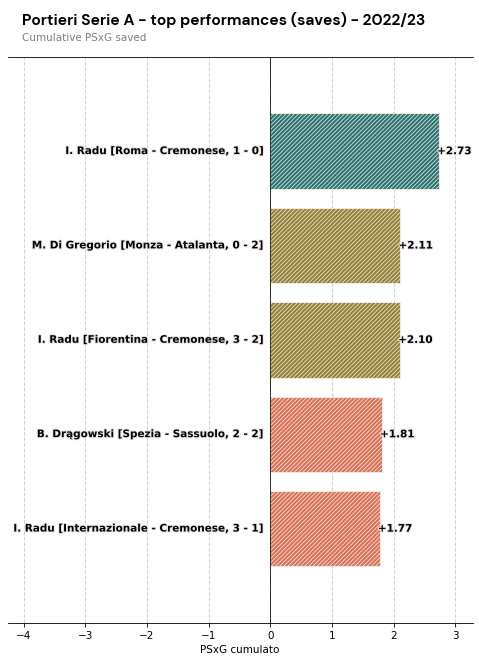

In [143]:
data = df_final_goals_GK_gameweek_TOP_saves


fig = plt.figure(figsize=(8,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(data['PSxG_sum'].min()), data['PSxG_sum'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.2)
ax.set_xlim(-max_*1.3, max_)
ax.set_ylim(-1, data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('PSxG cumulato', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=data['PSxG_sum'].min(),vmax=data['PSxG_sum'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    data.index, data['PSxG_sum'],
    hatch='//////', ec='#efe9e6',
    color = cmap(norm(data['PSxG_sum'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

for index, x in enumerate(data['PSxG_sum']):
    if x < 0:
        sign_offset = -1
        offset_logo = .15
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = .65
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*15,0),
        text=f'{sign_text}{x:.2f}',
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    
for index, row in data.iterrows():
    if row['PSxG_sum'] < 0:
        sign_offset = +1
        offset_logo = .15
        ha = 'left'
        #sign_text = ''
    else:
        sign_offset = -1
        offset_logo = .65
        ha = 'right'
        #sign_text = '+'
    text_ = ax.annotate(
        xy=(0, index),
        xytext=(sign_offset*6,0),
        text=f'{row["GK_game"]}',
        weight='bold',
        ha=ha,
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])


    # -- Figure title and arrows --------------------------------
position_negative = data[data['PSxG_sum'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2


title1 = 'Portieri Serie A - top performances (saves) - 2022/23'
fig_text(
    x = 0.15, y = .92, 
    s = title1,
    va = 'bottom', ha = 'left',
    fontsize = 15, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = 'Cumulative PSxG saved',
    va = 'bottom', ha = 'left',
    fontsize = 10, color = 'gray'
)

filename1 = "figures/portieriA_22_23_top_performances.png"
plt.savefig(
	filename1,
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)


### Overall View

In [128]:
### All the game so far
df_GK_1_goals = df_GK_goals.groupby(['GKname'])
df_GK_1_saves = df_GK_saves.groupby(['GKname'])


df_final_saves_GK_1 = df_GK_1_saves.agg(PSxG_sum=pd.NamedAgg(column='PSxG', aggfunc='sum'),
            PSxG_ave=pd.NamedAgg(column='PSxG', aggfunc='mean'),
            PSxG_max=pd.NamedAgg(column='PSxG', aggfunc='max'),
            TotalSaves=pd.NamedAgg(column='GoalSaved', aggfunc='sum')).reset_index()
df_final_saves_GK_1.sort_values(by=['PSxG_ave'], inplace=True, ascending=False)
df_final_saves_GK_1.reset_index(drop=True, inplace=True)

df_final_goals_GK_1 = df_GK_1_goals.agg(PSxGA_sum=pd.NamedAgg(column='PSxG', aggfunc='sum'),
            PSxGA_ave=pd.NamedAgg(column='PSxG', aggfunc='mean'),
            PSxGA_max=pd.NamedAgg(column='PSxG', aggfunc='max'),
            TotalGoalsA=pd.NamedAgg(column='GoalAllowed', aggfunc='sum')).reset_index()
#fix own-goal
df_final_goals_GK_1.iloc[15, 3]=2
df_final_goals_GK_1.sort_values(by=['PSxGA_ave'], inplace=True, ascending=False)
df_final_goals_GK_1.reset_index(drop=True, inplace=True)

df_final = df_final_saves_GK_1.merge(df_final_goals_GK_1, on="GKname", how="outer").fillna(0)
df_final['TotalGoalsA'] = df_final['TotalGoalsA'].astype(int)

df_final['PSxG-GA'] = (df_final['PSxG_sum']-df_final['TotalGoalsA'])
df_final['PSxG-GA/PSxG'] = (df_final['PSxG_sum']-df_final['TotalGoalsA'])/df_final['PSxG_sum']
df_final.sort_values('PSxG-GA/PSxG', ascending=True, inplace=True)
df_final.reset_index(inplace=True)

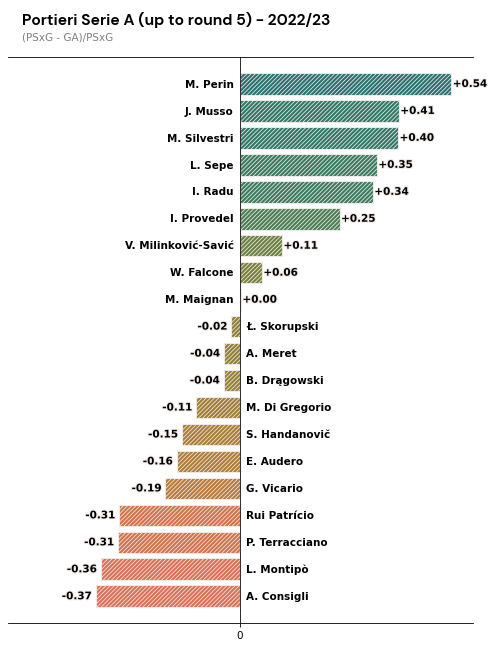

In [141]:
data1 = df_final[df_final.GKname!="W. Szczęsny"]
data = data1[data1.GKname!="P. Gollini"].reset_index(drop=True)
data.drop(['index'], axis=1, inplace=True)


fig = plt.figure(figsize=(8,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(data['PSxG-GA/PSxG'].min()), data['PSxG-GA/PSxG'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.set_xlabel('(PSxG-GA)/PSxG', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=data['PSxG-GA/PSxG'].min(),vmax=data['PSxG-GA/PSxG'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    data.index, data['PSxG-GA/PSxG'],
    hatch='//////', ec='#efe9e6',
    color = cmap(norm(data['PSxG-GA/PSxG'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)
# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

for index, x in enumerate(data['PSxG-GA/PSxG']):
    if x < 0:
        sign_offset = -1
        sign_text = ''
    else:
        sign_offset = 1
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*18,0),
        text=f'{sign_text}{x:.2f}',
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])
    
for index, row in data.iterrows():
    if row['PSxG-GA/PSxG'] < 0:
        sign_offset = +1
        ha = 'left'
    else:
        sign_offset = -1
        ha = 'right'
    text_ = ax.annotate(
        xy=(0, index),
        xytext=(sign_offset*6,0),
        text=f'{row["GKname"]}',
        weight='bold',
        ha=ha,
        va='center',
        textcoords='offset points'
    )


    # -- Figure title and arrows --------------------------------
position_negative = data[data['PSxG-GA/PSxG'] < 0].index.max()
position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))
ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2
ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='GK over performers',
    rotation=90,
    xytext=(-10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='GK under performers',
    rotation=-90,
    xytext=(10,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

textStr = 'Portieri Serie A (up to round '+str(gameweek)+') - 2022/23'
fig_text(
    x = 0.15, y = .92, 
    s = textStr,
    va = 'bottom', ha = 'left',
    fontsize = 15, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = '(PSxG - GA)/PSxG',
    va = 'bottom', ha = 'left',
    fontsize = 10, color = 'gray'
)

filenameStr = "figures/portieriA_22_23_overall_"+str(gameweek)+".png"
plt.savefig(
	filenameStr,
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)